# 8. Prediction Intervals for data streams

* How to utilise the prediction interval on regression tasks in CapyMOA
* Two methods for obtaining prediction intervals are currently available in CapyMOA: MVE and AdaPI

More details about prediction intervals for streaming data can be found in the AdaPI paper: 

[Yibin Sun, Bernhard Pfahringer, Heitor Murilo Gomes & Albert Bifet. "Adaptive Prediction Interval for Data Stream Regression." Pacific-Asia Conference on Knowledge Discovery and Data Mining. Springer, 2024.](https://link.springer.com/chapter/10.1007/978-981-97-2259-4_10)


---

*More information about CapyMOA can be found in* https://www.capymoa.org

**notebook last updated on 01/08/2024**

In [1]:
from capymoa.datasets import Fried

# load data
fried_stream = Fried()

## 1. Basic prediction interval learner build-up

* An example of the use case of prediction interval in CapyMOA
* Current available prediction interval learners require a regressive base model to work

In [2]:
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
)

## 2. Creating evaluators

* We involve two types of prediction interval evaluators so far: basic (cumulative) and windowed

In [3]:
from capymoa.evaluation.evaluation import (
    PredictionIntervalEvaluator,
    PredictionIntervalWindowedEvaluator,
)

# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(
    schema=fried_stream.get_schema(), window_size=1000
)

## 3. Running test-then-train/prequential tasks manually

**don't forget to train the models (call .train() function) at the end!**

In [4]:
# run test-then-train/prequential tasks
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

## 4. Results from both evaluators

In [5]:
# show results
print(
    f"MVE basic evaluation:\ncoverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.nmpiw()}"
)
print(
    f"MVE windowed evaluation in last window:\ncoverage: {mve_windowed_evaluator.coverage()}, \nNMPIW: {mve_windowed_evaluator.nmpiw()}"
)

MVE basic evaluation:
coverage: 97.28, NMPIW: 30.66
MVE windowed evaluation in last window:
coverage: [98.9, 98.1, 96.7, 97.7, 97.4, 97.7, 98.0, 97.8, 97.2, 96.8, 97.2, 97.9, 97.1, 97.5, 98.2, 97.8, 96.4, 97.4, 96.6, 97.3, 98.7, 96.4, 97.2, 97.0, 97.4, 96.0, 97.5, 97.1, 96.8, 96.7, 97.7, 97.2, 98.0, 96.1, 97.5, 97.2, 96.9, 97.2, 96.9, 96.7], 
NMPIW: [61.91, 46.44, 42.59, 43.82, 40.64, 40.08, 35.84, 38.32, 35.65, 39.25, 39.69, 36.09, 34.97, 34.95, 35.3, 34.79, 34.28, 33.46, 35.69, 35.64, 35.75, 35.03, 31.01, 33.91, 32.83, 33.54, 31.92, 31.31, 33.83, 32.07, 29.51, 33.25, 33.53, 31.93, 33.22, 29.3, 30.48, 29.39, 33.0, 32.14]


## 5. Wrap things up with prequential evaluation

* Prediction interval tasks also can be wrapped up with prequential evaluation in CapyMOA

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI

# restart stream
fried_stream.restart()
# specify regressive model
regressive_learner = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), base_learner=regressive_learner)
adapi_learner = AdaPI(
    schema=fried_stream.get_schema(), base_learner=regressive_learner, limit=0.001
)
# gather results
mve_results = prequential_evaluation(
    stream=fried_stream, learner=mve_learner, window_size=1000
)
adapi_results = prequential_evaluation(
    stream=fried_stream, learner=adapi_learner, window_size=1000
)

# show overall results
print(
    f"MVE coverage: {mve_results.cumulative.coverage()}, NMPIW: {mve_results.cumulative.nmpiw()}"
)
print(
    f"AdaPI coverage: {adapi_results.cumulative.coverage()}, NMPIW: {adapi_results.cumulative.nmpiw()}"
)

MVE coverage: 97.28, NMPIW: 30.66
AdaPI coverage: 96.15, NMPIW: 28.53


## 6. Plots are also supported

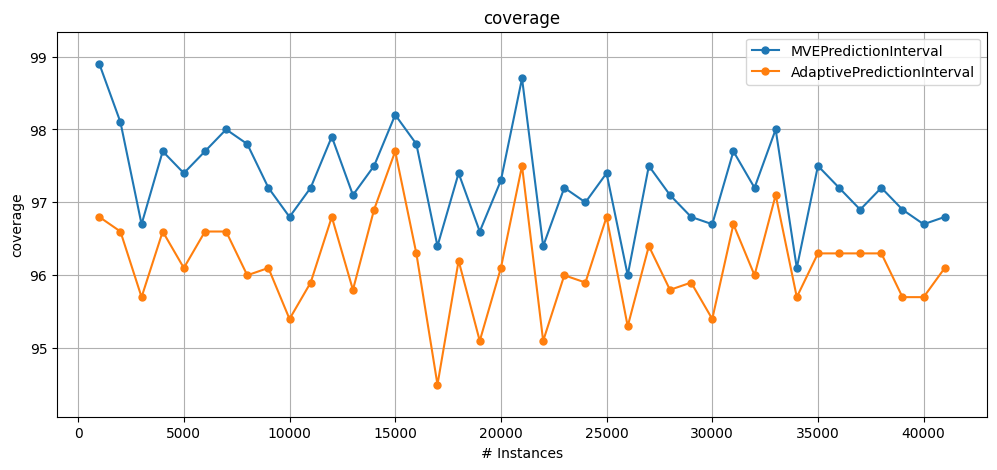

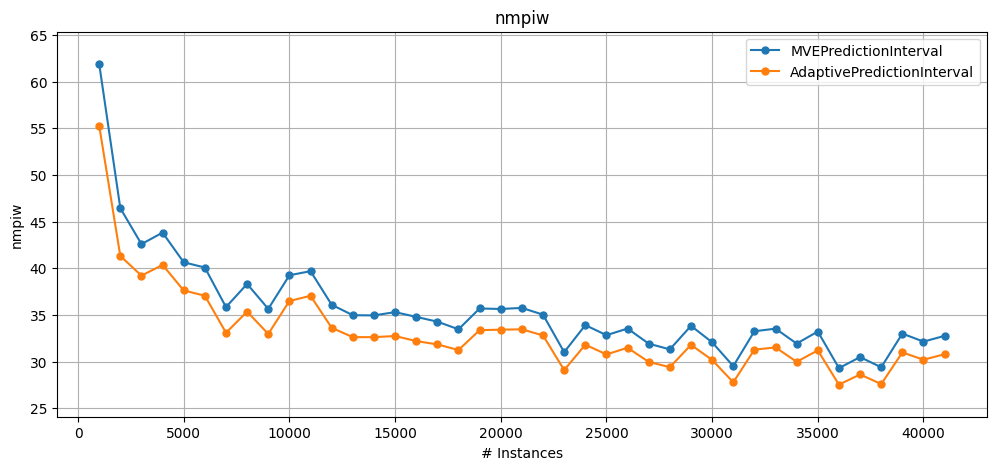

In [7]:
from capymoa.evaluation.visualization import plot_windowed_results

# plot over time comparison
plot_windowed_results(mve_results, adapi_results, metric="coverage")
plot_windowed_results(mve_results, adapi_results, metric="nmpiw")

### Plotting prediction intervals over time

* We also provide a visualization tool for plotting prediction intervals over time
* The function `plot_prediction_interval` can be used to plot the prediction intervals over time
* The function can take one of two prediction interval results as input

#### Single result plotting example
* In order to plot the prediction interval over time, we need to have store the predictions and the ground truth values in the prediction interval results
* The shaded area represents the prediction interval, while the solid line represents the regressive predictions.
* The stared-markers represent the ground truth values that are covered by the intervals.
* On the other hand, the cross-markers represent the ground truth values that are outside the intervals. 
* The colors can be adjusted by the `colors` parameter in the function as a list.
* `start` and `end` parameters can be used to specify the range of the plot.
* The `ground truth` and `predictions` can be omitted by setting the `plot_truth` and `plot_predictions` parameters to `False`.

**We have to set `optimise` to `Flase` to avoid subscribing problems**

In [8]:
new_mve_learner = MVE(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
)
new_mve_results = prequential_evaluation(
    stream=fried_stream,
    learner=new_mve_learner,
    window_size=1000,
    optimise=False,
    store_predictions=True,
    store_y=True,
)

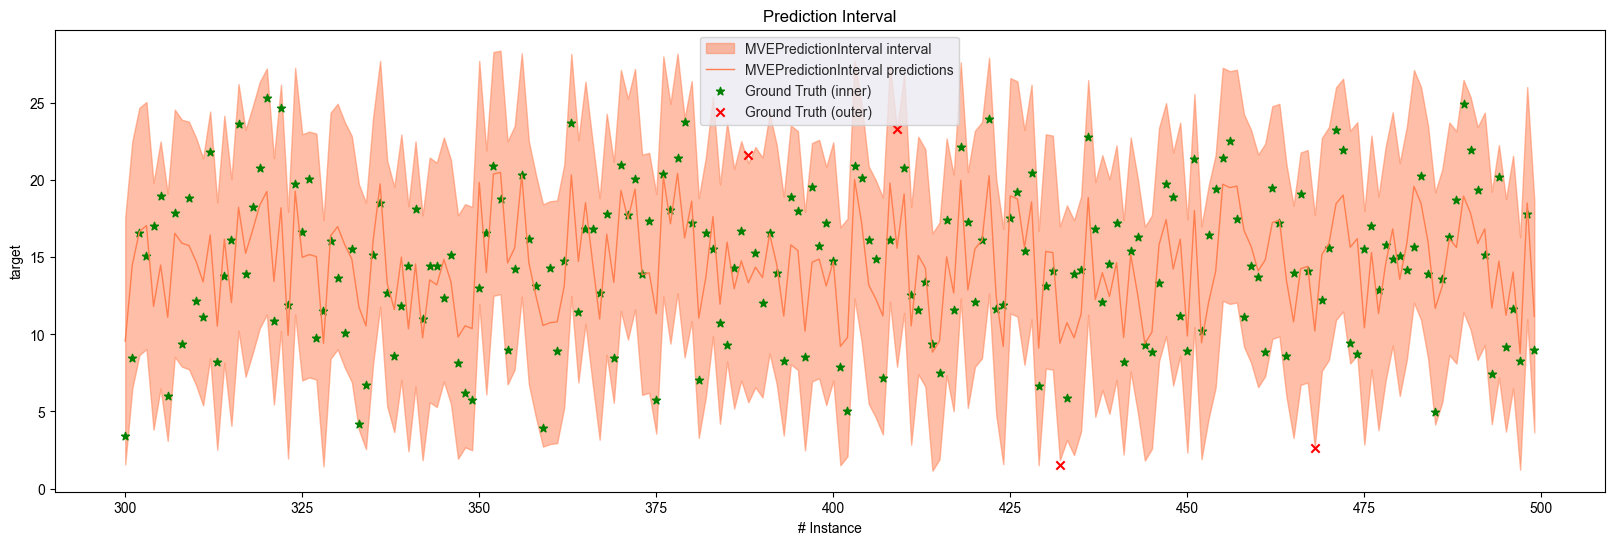

In [9]:
from capymoa.evaluation.visualization import plot_prediction_interval

plot_prediction_interval(new_mve_results, start=300, end=500, colors=["coral"])

#### Two results plotting example

* For comparison purposes, we can also plot two prediction interval results over time.
* We don't take more results since it makes the plot too messy to read.

In [10]:
# Let's add another results
new_adapi_learner = AdaPI(
    schema=fried_stream.get_schema(),
    base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10),
    limit=0.001,
)
new_adapi_results = prequential_evaluation(
    stream=fried_stream,
    learner=new_adapi_learner,
    window_size=1000,
    optimise=False,
    store_predictions=True,
    store_y=True,
)

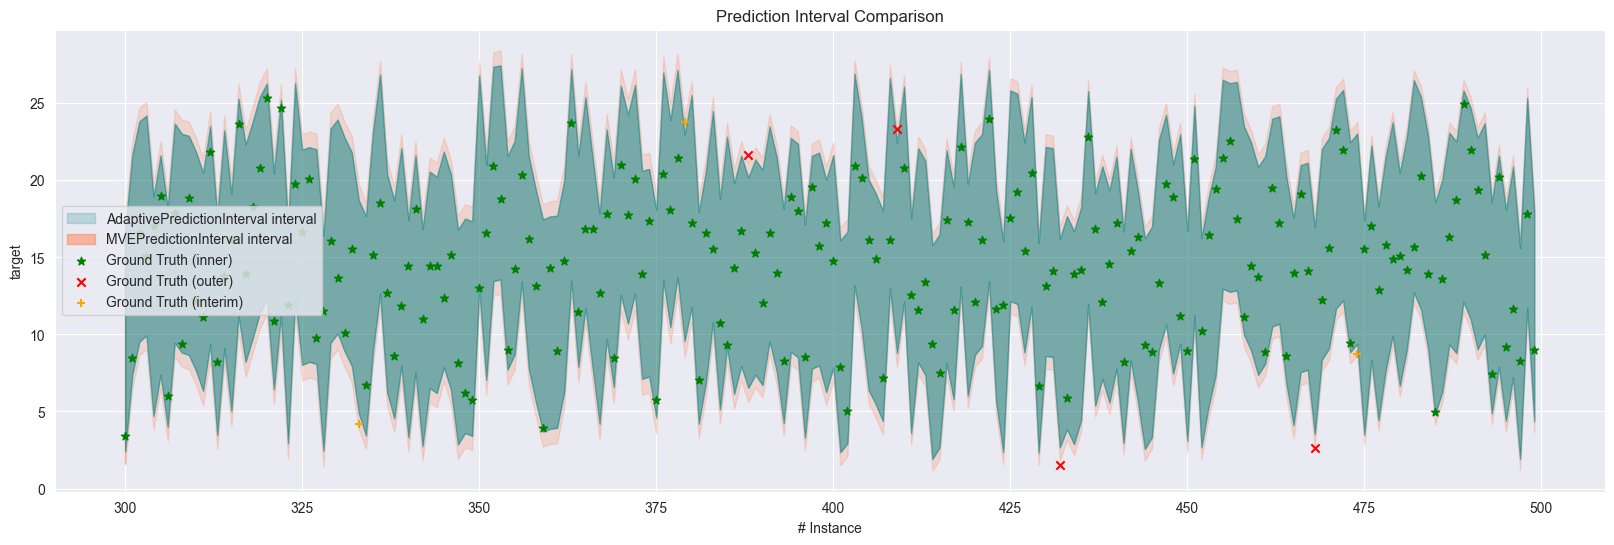

In [11]:
plot_prediction_interval(
    new_mve_results,
    new_adapi_results,
    start=300,
    end=500,
    colors=["coral", "teal"],
    plot_predictions=False,
)

* New "plus" markers represent the ground truth values that are covered by the narrower but not by wider intervals. 
* The function automatically puts the wider area to the back to make the narrower intervals more visible.